# Genderative AI

In [6]:
import datetime
import hashlib
import os
import shutil
import sqlite3
from functools import cache
from typing import Dict, List, NamedTuple, Union

import PIL
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import polars as pl
import seaborn as sns
import sklearn.metrics
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import display
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

if not torch.cuda.is_available():
    print("No GPU available, falling back to CPU")

In [121]:
# Helpers

# Functions
def current_time_only(file_safe: bool = False) -> str:
    """
    Returns the current time at second precision without date.

    Parameters:
    file_safe (bool): If True, returns time formatted for file naming (replaces ':' with '_').

    Returns:
    str: Current time formatted as 'HH:MM:SS' or 'DD_HH_MM_SS' if file_safe is True.
    """
    if file_safe:
        return datetime.datetime.now().strftime('%d:%H:%M:%S').replace(":", "_")
    else:
        return datetime.datetime.now().strftime('%H:%M:%S')


def count_files_in_directory(path: Union[str, 'LiteralString']) -> int:
    """
    Counts the number of files in a given directory.

    Parameters:
    path (Union[str, 'LiteralString']): The file path to the directory whose contents are to be counted.

    Raises:
    ValueError: If path is not a directory or does not exist.

    Returns:
    int: The number of files in the specified directory.
    """
    if not os.path.isdir(path):
        raise ValueError(f"{path} is not a directory.")
    return len(os.listdir(path))


def move_duplicate_files() -> list:
    """
    Identify and remove duplicate images.
    
    Sometimes it's possible that a given image being added to the training set has already been added, either to the same folder or to the validation folder. This can happen through user error or random chance. This function hashes all image files in the training and holdout folders, looks for duplicates, and moves the files.
    
    Note: Do not look for duplicates in the Unlabeled folder. Unlabeled images with low confidence are manually classified and copied into the training folder to improve model accuracy in future runs.
    
    :return: A list of file paths that were moved. The function's primary activity occurs via side effects.
    """
    file_path_list = []
    file_hash_data = pl.DataFrame(schema={"file_path": str, "file_hash": str})

    for outer_dir in ["Labeled", "Holdout"]:
        for inner_dir in ["Female", "Male"]:
            dir_path = os.path.join(data_dir, outer_dir, inner_dir)
            if not os.path.exists(dir_path):
                raise FileNotFoundError(
                    f"Directory does not exist: {dir_path}"
                )

            with os.scandir(dir_path) as entries:
                for entry in entries:
                    file_path_list.append(entry.path)
                    hasher = hashlib.sha512()
                    with open(entry.path, 'rb') as file_entry:
                        content = file_entry.read()
                        hasher.update(content)
                        this_entry_hash = hasher.hexdigest()
                        file_hash_data = pl.concat(
                            [file_hash_data, pl.DataFrame({"file_path": entry.path, "file_hash": this_entry_hash})])

    dupe_file_paths = list(set(file_hash_data.to_series().to_list()) - set(
        file_hash_data.sort("file_path").group_by("file_hash").last().select(
            "file_path").to_series().to_list()))
    for this_file_path in dupe_file_paths:
        os.replace(this_file_path, os.path.join(data_dir, "working_folder/temp", os.path.basename(this_file_path)))
    if len(dupe_file_paths) > 0:
        print(f"Moved {len(dupe_file_paths)} duplicate files")
    else:
        print("No duplicate files found")
    return dupe_file_paths


def get_dataset_structure_hash() -> str:
    """
    Get list of all training and holdout files. Uses data_dir to define base directory.

    Returns:
    str: SHA512 hash of the file names of all training and holdout files.
    """
    file_path_list = []

    for outer_dir in ["Labeled", "Holdout"]:
        for inner_dir in ["Female", "Male"]:
            dir_path = os.path.join(data_dir, outer_dir, inner_dir)

            if not os.path.exists(dir_path):
                raise FileNotFoundError(
                    f"Directory does not exist: {dir_path}"
                )

            with os.scandir(dir_path) as entries:
                for entry in entries:
                    file_path_list.append(entry.path)
    file_path_list.sort()
    file_path_list = "".join(file_path_list)
    file_path_list_hash = hashlib.sha512(file_path_list.encode()).hexdigest()
    return file_path_list_hash


def plot_training_progress(train_acc: list,
                           train_loss: list,
                           val_acc: list,
                           validation_loss: list,
                           title="Model results"):
    """
    Plot training-vs-testing accuracy and loss for each epoch.
    
    Parameters:
        train_acc (list): List of training accuracy values from each epoch, must be same length as val_acc
        train_loss (list): List of training loss values from each epoch, must be same length as val_loss
        val_acc (list): List of validation accuracy values from each epoch, must be same length as train_acc
        validation_loss (list): List of validation loss values from each epoch, must be same length as train_loss
        title (str): Plot title
    
    Raises:
        ValueError: If the lengths of accuracy or loss lists don't match each other
    """
    if not (len(train_acc) == len(val_acc) and len(train_loss) == len(validation_loss)) and len(train_acc) > 0 and len(
            train_loss) > 0:
        raise ValueError("Lengths of training and validation lists must match")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(train_acc,
                label="Training accuracy",
                color=train_color,
                linewidth=3)
    axs[0].plot(val_acc,
                label="Validation accuracy",
                color=val_color,
                linewidth=3)
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_loss,
                label="Training loss",
                color=train_color,
                linewidth=3)
    axs[1].plot(validation_loss,
                label="Validation loss",
                color=val_color,
                linewidth=3)
    axs[1].set_title("Loss")
    axs[1].set(ylim=(0, None))
    axs[1].legend()

    fig.suptitle(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


def add_occupation(image_data_frame: pl.DataFrame) -> pl.DataFrame:
    """
    Adds an 'occupation' column to the DataFrame by first neutralizing gender-specific terms 
    in the 'file_path' column and then extracting the occupation.

    The function first removes 'female_' or 'male_' from the 'file_path', then assumes that 
    the occupation is embedded in the modified file path string, following a specific pattern 
    (fourth underscore-separated value after removal of gender terms).

    If an occupation is not found (null value), it prints a warning with the file path.

    Parameters:
    image_data_frame (pl.DataFrame): A DataFrame with a column named 'file_path'.

    Returns:
    pl.DataFrame: The original DataFrame with an added 'occupation' column.

    Raises:
    ValueError: If the 'file_path' column does not exist in the DataFrame.
    """
    if 'file_path' not in image_data_frame.columns:
        raise ValueError("The DataFrame must contain a 'file_path' column.")

    image_data_frame = image_data_frame.with_columns([
        pl.col("file_path")
        .str.replace(pattern="(female_|male_)", value="")
        .map_elements(lambda x: x.split(".jpeg")[0] if ".jpeg" in x else x)
        .str.extract("(?:[^_]*_){4}([^_]*)_")
        .str.replace("dietitian", "nutritionist")
        .alias("occupation")
    ])

    # Check for null occupations and print warning
    for row in image_data_frame.filter(pl.col("occupation").is_null()).to_dicts():
        print(f"Warning: Null occupation found for file path: {row['file_path']}")

    return image_data_frame


def label_images(csv_file: str, output_file: str):
    """
    Reads images from a specified CSV file and allows the user to label them interactively.

    This function opens each image specified in the CSV file and displays it to the user. 
    The user can then label the image as 'Female', 'Male', or 'Discard' by pressing the corresponding 
    keys ('f', 'm', 'd' or '0', '1', '2'). The function logs the user's decision along with the image 
    path and writes this data to an output file.

    Parameters:
    csv_file (str): Path to the CSV file containing the paths of the images to be labeled.
    output_file (str): Path to the output CSV file where the image paths and labels will be saved.

    Raises:
    ValueError: If a key pressed is not among the specified keys ('f', 'm', 'd', '0', '1', '2').

    Notes:
    The function adds a text overlay to each image before displaying it, which indicates the keys 
    for labeling. If an image cannot be read, it logs the path with the label "ERROR".
    """
    image_labels = []
    image_files = pl.read_csv(csv_file).to_series().to_list()
    image_files_length = len(image_files)

    for image_path in image_files:
        image = cv2.imread(image_path)
        if image is not None:
            cv2.putText(image, "'F'emale, 'M'ale, 'D'iscard", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.imshow("Image", image)

            key = cv2.waitKey(0)  # Wait for a key press
            if key == ord('0') or key == ord('f'):
                image_labels.append((image_path, "Female"))
            elif key == ord('1') or key == ord('m'):
                image_labels.append((image_path, "Male"))
            elif key == ord('2') or key == ord('d'):
                image_labels.append((image_path, "Discard"))
            else:
                raise ValueError("Only allowed values are 0, 1, 2, f, m, and d")
            image_index = image_files.index(image_path) + 1
            print(f"Image {image_index}/{image_files_length} classified as {chr(key)}")

            cv2.destroyAllWindows()
        else:
            print(f"Could not read image: {image_path}")
            image_labels.append((image_path, "ERROR"))

    with open(output_file, 'w') as f:
        for item in image_labels:
            f.write(f"{item[0]},{item[1]}\n")


@cache
def calculate_normalization(custom_normalization: bool, hash_value: str) -> Dict[str, List[float]]:
    """
    Calculates the mean and standard deviation of the dataset for normalization.

    Parameters:
    custom_normalization (bool): Determines if custom normalization values are to be calculated.
    hash_value (str): The hash value of the dataset structure. Used for cache invalidation.

    Returns:
    Dict[str, List[float]]: A dictionary containing 'mean' and 'std', each a list of three floats.

    Notes:
    Function uses global variables batch_size and data_dir.
    """
    # No-op to satisfy IDE checks
    _ = len(hash_value)

    if custom_normalization:
        # Create a dataset without normalization
        unnormalized_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=tensor_transform)
        unnormalized_loader = DataLoader(unnormalized_dataset, batch_size=batch_size, shuffle=True)

        def calculate_mean_std(loader: DataLoader) -> (torch.Tensor, torch.Tensor):
            """
            Calculate the mean and standard deviation of images in a DataLoader.
        
            Parameters:
            loader (DataLoader): The DataLoader containing the dataset.
        
            Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation tensors.
            """
            mean_accumulator = 0.0
            variance_accumulator = 0.0
            for images, _ in loader:
                batch_samples = images.size(0)
                images = images.view(batch_samples, images.size(1), -1)
                mean_accumulator += images.mean(2).sum(0)
                variance_accumulator += images.var(2).sum(0)

            mean_accumulator /= len(loader.dataset)
            std_deviation = torch.sqrt(variance_accumulator / len(loader.dataset))
            return mean_accumulator, std_deviation

        dataset_mean, dataset_std = calculate_mean_std(unnormalized_loader)
        normalization_dict = {'mean': dataset_mean.tolist(), 'std': dataset_std.tolist()}
        del unnormalized_dataset, unnormalized_loader
        print(f"Custom normalization values: {normalization_dict}")
    else:
        normalization_dict = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
        print("Standard normalization values used")
    return normalization_dict


def display_images_from_dataloader(dataloader: DataLoader, num_images: int = 8):
    """
    Fetches a batch of images from the given DataLoader and displays them to user.
    
    Parameters:
    dataloader (DataLoader): A PyTorch DataLoader object from which to fetch the images.
    num_images (int): The number of images to display from the batch.
    """

    def imshow(img: torch.Tensor):
        """
        Display an image by denormalizing and clipping its values.

        This function takes a PyTorch tensor representing a grid of images, which have been normalized 
        previously, and performs denormalization to convert them back to their original color 
        space. It then clips the image values to be within the range [0, 1] to ensure 
        proper display. The image is displayed using matplotlib.

        Parameters:
        img (torch.Tensor): A PyTorch tensor representing a grid of images.
        """
        img = img.numpy().transpose((1, 2, 0))
        img = normalization_values['std'] * img + normalization_values['mean']  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    num_images = min(batch_size, num_images)
    dataset_images, dataset_labels = next(iter(dataloader))
    images_subset = dataset_images[:num_images]
    imshow(torchvision.utils.make_grid(images_subset))
    print(' '.join(f'{classes[dataset_labels[j]]:5s}' for j in range(num_images)))


def predict_model_resnet(my_dataloader):
    """
    Performs predictions using a ResNet model on a given dataloader.
    
    This function runs the ResNet model in evaluation mode and generates predictions for the input data. 
    It requires the dataloader to have a batch size of exactly 1. The function outputs a dataframe 
    with file paths, actual labels, predicted labels, probabilities of being female, and a flag indicating 
    correct predictions.
    
    Note: The sorting logic in the function is based on the condition of correct predictions and their confidence scores.
    
    Parameters:
    my_dataloader (Dataloader): A PyTorch Dataloader object containing the data to be predicted. 
                                 The dataloader must have a batch size of 1.
    
    Raises:
    ValueError: If the dataloader's batch size is not 1.
    
    Returns:
    Polars.DataFrame: A dataframe containing columns for file paths, labels, predictions, 
                      probabilities, and correct predictions.
    """
    if my_dataloader.batch_size != 1:
        raise ValueError("Predictions dataloader requires batch size of exactly 1")
    model_resnet.eval()
    prediction_results = pl.DataFrame(schema={"file_path": str, "label": int, "prediction": int, "prob_female": float})
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(my_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            prob_female = torch.nn.functional.softmax(outputs, dim=1)[:, 0].tolist()
            predicted = predicted.tolist()
            labels = labels.tolist()
            file_paths = my_dataloader.dataset.samples[i][0]
            batch_results = pl.DataFrame({"file_path": file_paths,
                                          "label": labels,
                                          "prediction": predicted,
                                          "prob_female": prob_female})
            prediction_results = pl.concat([prediction_results, batch_results], how="vertical_relaxed")
        prediction_results = prediction_results.with_columns(
            (1 * (pl.col("label") == pl.col("prediction"))).alias("correct_prediction")
        )
        # I couldn't figure out the sorting logic so I asked SO
        # https://stackoverflow.com/questions/77700489/how-to-perform-a-conditional-sort-in-polars/77700711
        prediction_results = prediction_results.with_columns(
            abs(pl.col("prob_female") - 0.5).alias("confidence")
        ).sort([
            (good_prediction := pl.col('label').eq(pl.col('prediction'))),
            (good_prediction - 1) * pl.col('confidence'),
            pl.col('confidence')
        ])
        return prediction_results


def move_image(file_path, new_folder) -> None:
    """
    Move image located at file_path to new_folder.
    
    :param file_path: Location of file to be moved.
    :param new_folder: Folder where you want the file to be moved.
    :return: None
    """
    new_path = os.path.join(data_dir, new_folder, os.path.basename(file_path))
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    try:
        shutil.move(file_path, new_path)
        print(f"File {file_path} successfully moved to {new_folder}")
        with open("file_move_history.txt", 'a') as f:
            f.write(f"{file_path}\n")
    except FileNotFoundError as e:
        print(f"File not found: {file_path}: {e}")
    except PermissionError as e:
        print(f"Permission error: {file_path}: {e}")


def move_labeled_images(image_label_dataframe_path: str = "labels.csv"):
    image_label_dataframe = pl.read_csv(image_label_dataframe_path,
                                        has_header=False,
                                        new_columns=["file_path", "gender"],
                                        schema={"file_path": pl.Utf8, "gender": pl.Utf8}).with_columns(
        # Only allow the three valid image labels
        pl.col("gender").cast(pl.Enum(categories=["Female", "Male", "Discard"]))
    )

    for row in image_label_dataframe.iter_rows():
        file_path, label = row
        sub_folder = file_path.replace(data_dir, "", 1).strip(os.sep).split(os.sep)[0].lstrip()
        sub_folder = data_dir + sub_folder
        destination_folder = os.path.join(sub_folder, label)
        current_folder = os.path.dirname(file_path)
        # Check if the current folder is the same as the destination folder
        if current_folder != destination_folder:
            if os.path.isfile(file_path):
                move_image(file_path, destination_folder)
            else:
                print(f"Image not found: {file_path}")
        else:
            print(f"File is already in the correct folder: {file_path}")
            with open("file_move_history.txt", 'a') as f:
                f.write(f"{file_path}\n")

def get_occupation_counts() -> pl.DataFrame:
    """Gets occupation count breakdown by gender for labeled and holdout data.
    
    This function walks through the labeled and holdout image subfolders, extracts 
    the occupation from the file path, and aggregates a count by occupation and 
    gender. It then pivots the data to compare female and male counts by occupation.
    
    The output DataFrame contains:
    - subfolder: Labeled or Holdout 
    - Occupation
    - Count by gender
    - Absolute difference in counts
    - Percent difference 
    
    Returns:
    pl.DataFrame: Breakdown of occupation counts by gender for labeled and holdout data.
    """
    subfolder_gender_occupation_count = pl.DataFrame(
        schema={"directory": str, "subfolder": str, "gender": str, "occupation": str}
    )
    
    for this_subfolder in ["labeled", "holdout"]:
        for this_gender in ["female", "male"]:
            for root, dirs, files in os.walk(
                    os.path.join(data_dir, this_subfolder, this_gender)
            ):
                if len(files) == 0:
                    raise ValueError(f"Empty directory: {root}")
                root = str(root).replace(data_dir, "", 1)
                subfolder_gender_occupation_count.extend(
                    add_occupation(
                        pl.DataFrame(
                            {
                                "directory": [root] * len(files),
                                "subfolder": [this_subfolder] * len(files),
                                "gender": [this_gender] * len(files),
                                "file_path": files,
                            }
                        )
                    )
                    .drop("file_path")
                    .sort(["directory", "occupation"])
                )
    subfolder_gender_occupation_summary = (
        subfolder_gender_occupation_count.group_by(
            ["directory", "subfolder", "gender", "occupation"]
        )
        .agg(pl.count())
        .sort(["directory", "occupation"])
    ).with_columns(
        pl.col("count").cast(pl.Int32)
    )
    
    subfolder_gender_occupation_summary = (subfolder_gender_occupation_summary.pivot(
        values="count",
        index=["subfolder", "occupation"],
        columns="gender",
        aggregate_function=None
    ))
    
    return (subfolder_gender_occupation_summary.with_columns(
        abs(pl.col("male").sub(pl.col("female"))).alias("gender_difference")
    ).with_columns(
        pl.col("gender_difference").truediv((pl.col("female").add(pl.col("male")))).alias("gender_difference_pct"))
    ).sort(["subfolder", "gender_difference_pct", "gender_difference", "female"], descending=True)


def calculate_metrics(subset_df: pl.DataFrame) -> pl.DataFrame:
    """Calculates model evaluation metrics on a subset of predictions.
    
    This function takes a DataFrame containing ground truth labels, predictions,
    and predicted probabilities. It calculates a suite of common classification
    evaluation metrics.
    
    The metrics calculated are:
    - Accuracy
    - ROC AUC
    - Precision
    - Recall
    - F1 Score
    - Matthews Correlation Coefficient
    - Cohen's Kappa
    - PR AUC
    - Brier Score
    - Hamming Loss
    - Jaccard Loss
    - Number of samples
    
    Parameters:
    subset_df (pl.DataFrame): DataFrame with columns for labels, predictions, probabilities
    
    Returns:
    pl.DataFrame: DataFrame containing metric values, along with the occupation
    """
    y_true = subset_df['label']
    y_pred = subset_df['prediction']
    y_prob = subset_df['prob_male']

    this_occupation = subset_df['occupation'].unique()
    if len(this_occupation) > 1:
        this_occupation = "OVERALL"

    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    roc_auc = sklearn.metrics.roc_auc_score(y_true, y_prob)
    precision = sklearn.metrics.precision_score(y_true, y_pred)
    recall = sklearn.metrics.recall_score(y_true, y_pred)
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    matthews_corrcoef = sklearn.metrics.matthews_corrcoef(y_true, y_pred)
    cohen_kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred)
    precision_curve, recall_curve, _ = sklearn.metrics.precision_recall_curve(y_true, y_prob)
    pr_auc = sklearn.metrics.auc(recall_curve, precision_curve)
    brier_score = sklearn.metrics.brier_score_loss(y_true, y_prob)
    hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)
    jaccard_loss = 1 - sklearn.metrics.jaccard_score(y_true, y_pred)
    n_samples = subset_df.shape[0]

    return pl.DataFrame({
        "occupation": this_occupation,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "matthews_corrcoef": matthews_corrcoef,
        "cohen_kappa": cohen_kappa,
        "pr_auc": pr_auc,
        "brier_score": brier_score,
        "hamming_loss": hamming_loss,
        "jaccard_loss": jaccard_loss,
        "n": n_samples
    })


# Classes
class ImbalancedClassesException(ValueError):
    """Exception raised when classes must be perfectly balanced and are not."""


class Colors(NamedTuple):
    train: str
    val: str
    unlabeled: str

In [122]:
# Config variables
colors = Colors(train="#ff130f", val="#7fff0f", unlabeled="#0fefff")
train_color = colors.train
val_color = colors.val
unlabeled_color = colors.unlabeled

data_dir: str = 'H:/Photos/AI/'
batch_size: int = 30
classes: tuple[str, str] = ('Female', 'Male')
use_custom_normalization: bool = True
num_epochs: int = 5

In [123]:
moved_file_path_list = move_duplicate_files()

No duplicate files found


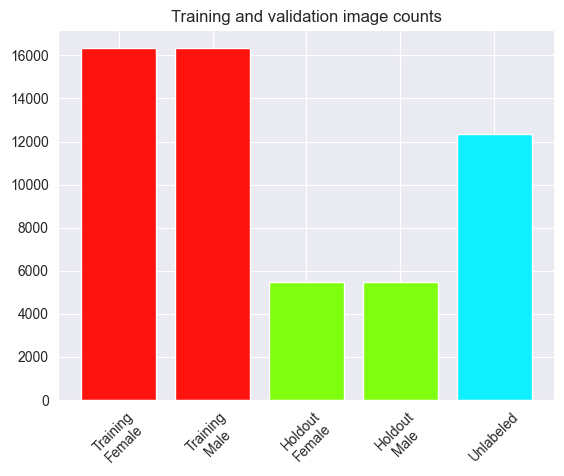

In [124]:
# Count the number of images in each training folder and throw exception if imbalanced
dataset_structure_hash = get_dataset_structure_hash()
file_counts = {category: {gender: count_files_in_directory(
    os.path.join(data_dir, category, gender))
    for gender in classes}
    for category in ['Labeled', 'Holdout']}
file_counts.update({'Unlabeled': count_files_in_directory(os.path.join(data_dir, "Unlabeled/Unlabeled"))})

fig, ax = plt.subplots()
ax.bar(['Training\nFemale', 'Training\nMale',
        'Holdout\nFemale', 'Holdout\nMale',
        'Unlabeled'],
       [file_counts['Labeled']['Female'],
        file_counts['Labeled']['Male'],
        file_counts['Holdout']['Female'],
        file_counts['Holdout']['Male'],
        file_counts['Unlabeled']],
       color=[train_color, train_color, val_color, val_color, unlabeled_color])
plt.xticks(rotation=45)
plt.title("Training and validation image counts")
plt.show()

if file_counts['Labeled']['Female'] != file_counts['Labeled']['Male']:
    female_count = file_counts['Labeled']['Female']
    male_count = file_counts['Labeled']['Male']
    raise ImbalancedClassesException(
        f'Imbalance detected: {female_count} female images vs {male_count} male images')

In [125]:
get_occupation_counts()

subfolder,occupation,female,male,gender_difference,gender_difference_pct
str,str,i32,i32,i32,f64
"""labeled""","""nurse""",2722,2722,0,0.0
"""labeled""","""pharmacist""",2557,2557,0,0.0
"""labeled""","""doctor""",2457,2457,0,0.0
"""labeled""","""nutritionist""",1334,1334,0,0.0
"""labeled""","""paramedic""",1007,1007,0,0.0
"""labeled""","""social""",852,852,0,0.0
"""labeled""","""veterinarian""",764,764,0,0.0
"""labeled""","""psychologist""",574,574,0,0.0
"""labeled""","""dentist""",564,564,0,0.0


In [10]:
tensor_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

normalization_values = calculate_normalization(use_custom_normalization, dataset_structure_hash)

Custom normalization values: {'mean': [0.48970767855644226, 0.4791847765445709, 0.4730803668498993], 'std': [0.29445311427116394, 0.2689289450645447, 0.27757835388183594]}


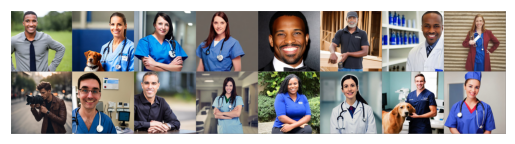

Male  Female Female Female Male  Male  Male  Female Male  Male  Male  Female Female Female Male  Female


In [11]:
# Load train/test images in Pytorch format
transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Images are already 512x512, but it's good to be sure
    transforms.ToTensor(),
    transforms.Normalize(mean=normalization_values['mean'], std=normalization_values['std'])
])

train_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageFolder(os.path.join(data_dir, 'Holdout'), transform=transformations)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

display_images_from_dataloader(train_loader, num_images=16)

# ResNet model

In [12]:
# Load a pre-trained ResNet model
# Available sizes are 18, 34, 50, 101, 152
#model_resnet = models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2)
#model_resnet.name = "ResNet152v2"
model_resnet = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model_resnet.name = "ResNet18"

# Freeze the layers except the final layer
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer for binary classification
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 2)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

In [13]:
resnet_train_epoch_loss = []
resnet_train_epoch_accuracy = []
resnet_validation_epoch_loss = []
resnet_validation_epoch_accuracy = []
model_training_start_time = datetime.datetime.now().timestamp()

# Fine-tune the ResNet model
for epoch in range(num_epochs):
    model_resnet.train()
    print(f"Epoch {epoch + 1} initiated")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        if i % 250 == 0:
            print(f"Training batch {i + 1}/{len(train_loader)} ({current_time_only()})")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    resnet_train_epoch_loss.append(running_loss / len(train_loader))
    resnet_train_epoch_accuracy.append(correct_train / total_train)

    # Validation
    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        print(f"Validation started ({current_time_only()})")
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = correct / total
    resnet_validation_epoch_loss.append(epoch_val_loss)
    resnet_validation_epoch_accuracy.append(epoch_val_accuracy)

    # Extra fancy console output
    print("\n" + "*" * 50)
    print(f"{'*' * 10} EPOCH {epoch + 1} RESULTS {'*' * 10}".center(50))
    print("*" * 50)
    print(f'\033[94mTrain Loss: {running_loss / len(train_loader):.3f}\033[0m, '
          f'\033[92mValidation Loss: {epoch_val_loss:.3f}\033[0m, '
          f'\033[93mTraining Accuracy: {100 * correct_train / total_train:.2f}%\033[0m, '
          f'\033[91mValidation Accuracy: {100 * epoch_val_accuracy:.2f}%\033[0m')
    print("*" * 50 + "\n")

    # Write data to a .csv as a backup to the sqlite database
    with open("training_log.csv", 'a') as f:
        # Save epoch metrics
        # Column names: model_training_start_time, model_name, batch_size, epoch, train_loss,
        # val_loss, train_accuracy, val_accuracy, epoch_completion_timestamp, dataset_structure_hash
        f.write(
            f"{model_training_start_time},{model_resnet.name},{batch_size},{epoch + 1},{running_loss / len(train_loader)},"
            f"{epoch_val_loss},{100 * correct_train / total_train},{100 * epoch_val_accuracy},"
            f"{datetime.datetime.now().timestamp()},{dataset_structure_hash}\n")

    # Prepare data for insertion
    data_to_insert = (model_training_start_time, model_resnet.name, batch_size, epoch + 1,
                      running_loss / len(train_loader), epoch_val_loss,
                      100 * correct_train / total_train, 100 * epoch_val_accuracy,
                      datetime.datetime.now().timestamp(), dataset_structure_hash)

    # Prepare INSERT INTO statement
    insert_query = """INSERT INTO training_log (model_training_start_time, model_name, batch_size, epoch, train_loss, 
                    val_loss, train_accuracy, val_accuracy, epoch_completion_timestamp, dataset_structure_hash) 
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);"""

    con = sqlite3.connect("genderative_ai_database.db")
    cur = con.cursor()
    cur.execute(insert_query, data_to_insert)
    con.commit()
    con.close()

print(f'Finished Training ({current_time_only()})')

Epoch 1 initiated
Training batch 1/1076 (07:42:02)
Training batch 251/1076 (07:46:48)
Training batch 501/1076 (07:50:11)
Training batch 751/1076 (07:54:51)
Training batch 1001/1076 (08:00:28)
Validation started (08:02:08)

**************************************************
      ********** EPOCH 1 RESULTS **********       
**************************************************
Train Loss: 0.278, Validation Loss: 0.153, Training Accuracy: 89.56%, Validation Accuracy: 95.64%
**************************************************

Epoch 2 initiated
Training batch 1/1076 (08:08:52)
Training batch 251/1076 (08:13:31)
Training batch 501/1076 (08:18:10)
Training batch 751/1076 (08:22:52)
Training batch 1001/1076 (08:27:01)
Validation started (08:28:14)

**************************************************
      ********** EPOCH 2 RESULTS **********       
**************************************************
Train Loss: 0.179, Validation Loss: 0.122, Training Accuracy: 93.39%, Validation Accuracy: 96.18%


In [14]:
torch.save(model_resnet, f"{model_resnet.name}_{int(datetime.datetime.now().timestamp())}.pt")

In [15]:
# Load most recent model
#model_files = [f for f in os.listdir() if f.startswith("ResNet")]
#model_files.sort()
#model_resnet = torch.load(model_files[-1])

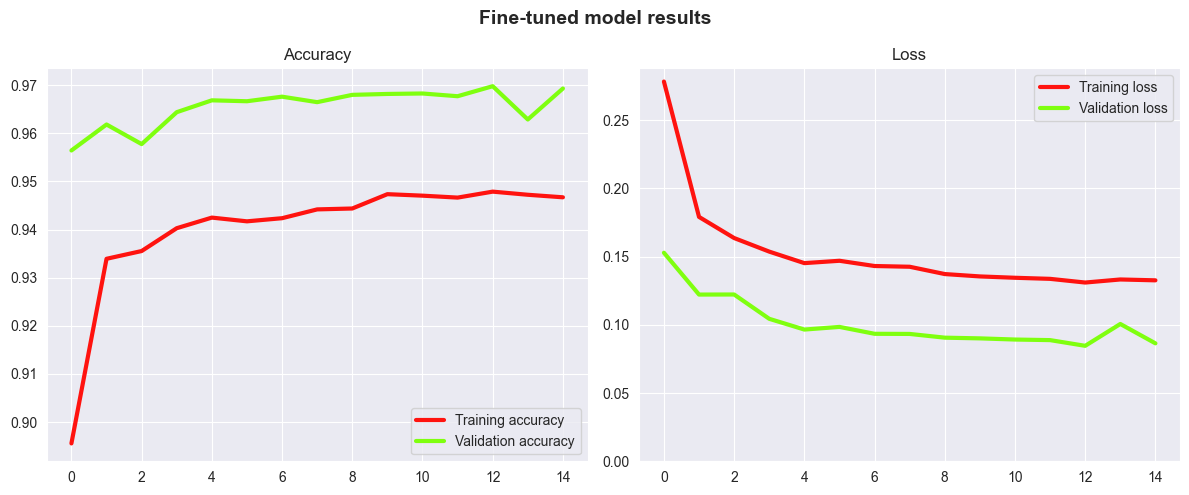

In [16]:
plot_training_progress(train_acc=resnet_train_epoch_accuracy,
                       train_loss=resnet_train_epoch_loss,
                       val_acc=resnet_validation_epoch_accuracy,
                       validation_loss=resnet_validation_epoch_loss,
                       title="Fine-tuned model results")

# Training history

In [102]:
training_log_schema = {"key": pl.UInt32,
                       "model_training_start_time": pl.Float64,
                       "model_name": pl.Utf8,
                       "batch_size": pl.UInt64,
                       "epoch": pl.UInt64,
                       "train_loss": pl.Float64,
                       "val_loss": pl.Float64,
                       "train_accuracy": pl.Float64,
                       "val_accuracy": pl.Float64,
                       "epoch_completion_timestamp": pl.Float64,
                       "dataset_structure_hash": pl.Utf8}

con = sqlite3.connect("genderative_ai_database.db")
cur = con.cursor()
training_log = pl.DataFrame(cur.execute("SELECT * FROM training_log").fetchall(),
                            schema=training_log_schema).with_columns(
    (pl.col("epoch_completion_timestamp") - pl.col("model_training_start_time")).alias("training_duration")
)

training_log_latest = (pl.DataFrame(cur.execute("""
    WITH latest_dataset_hash AS (
        SELECT dataset_structure_hash
        FROM training_log
        ORDER BY epoch_completion_timestamp DESC
        LIMIT 1
    )
    SELECT *
    FROM training_log
    WHERE dataset_structure_hash IN (SELECT dataset_structure_hash FROM latest_dataset_hash);
""").fetchall(),
                                    schema=training_log_schema)
.drop("key")
.with_columns(
    (pl.col("epoch_completion_timestamp") - pl.col("model_training_start_time")).alias("training_duration")
))
con.close()

training_log_by_model = (
    training_log
    .lazy()
    .group_by(["model_name", "batch_size", "epoch"])
    .agg(
        pl.median("train_loss").alias("train_loss"),
        pl.median("val_loss").alias("val_loss"),
        pl.median("train_accuracy").alias("train_accuracy"),
        pl.median("val_accuracy").alias("val_accuracy"),
        pl.median("training_duration").alias("training_duration"),
        pl.count().alias("n")
    )
    .sort('val_accuracy', descending=True)
    .collect()
)

training_log_latest_by_model = (
    training_log_latest
    .lazy()
    .group_by(["model_name", "batch_size", "epoch"])
    .agg(
        pl.median("train_loss").alias("train_loss"),
        pl.median("val_loss").alias("val_loss"),
        pl.median("train_accuracy").alias("train_accuracy"),
        pl.median("val_accuracy").alias("val_accuracy"),
        pl.median("training_duration").alias("training_duration"),
        pl.count().alias("n")
    )
    .sort('val_accuracy', descending=True)
    .collect()
)

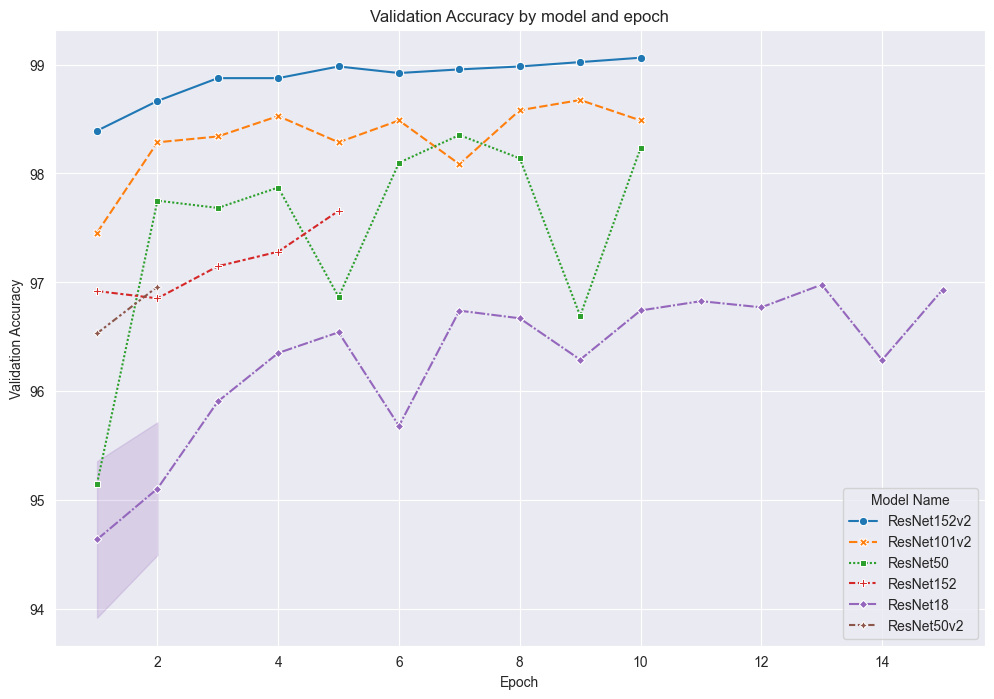

In [103]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=training_log_by_model, x="epoch", y="val_accuracy", hue="model_name", style="model_name",
             markers=True)
plt.title('Validation Accuracy by model and epoch (all training runs)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name', loc='lower right')
plt.show()

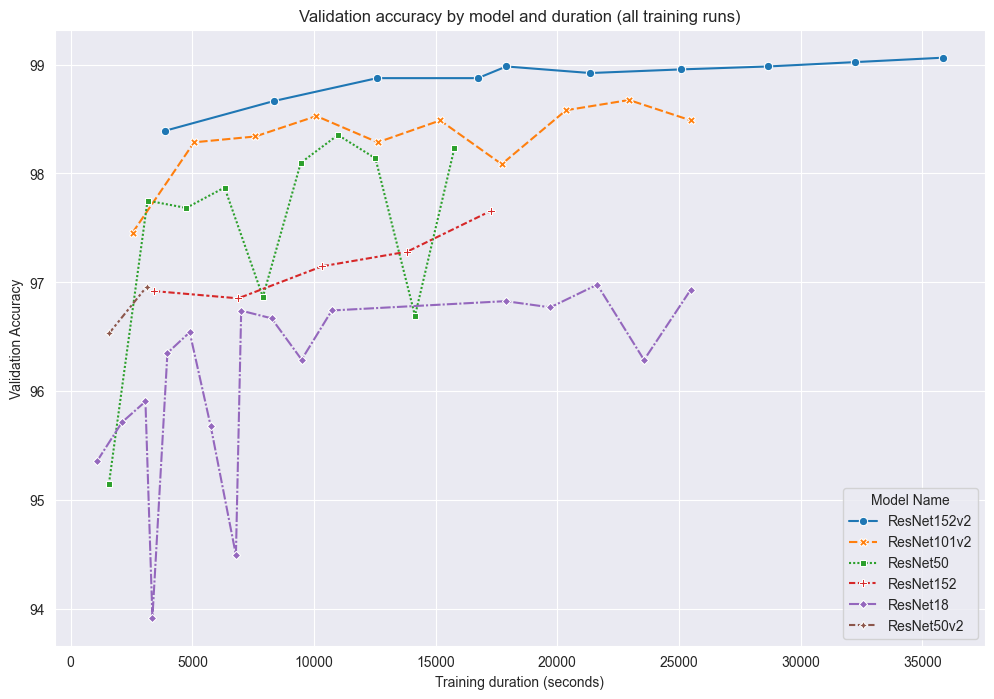

In [108]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=training_log_by_model, x="training_duration", y="val_accuracy", hue="model_name", style="model_name",
             markers=True)
plt.title('Validation accuracy by model and duration (all training runs)')
plt.xlabel('Training duration (seconds)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name', loc='lower right')
plt.show()

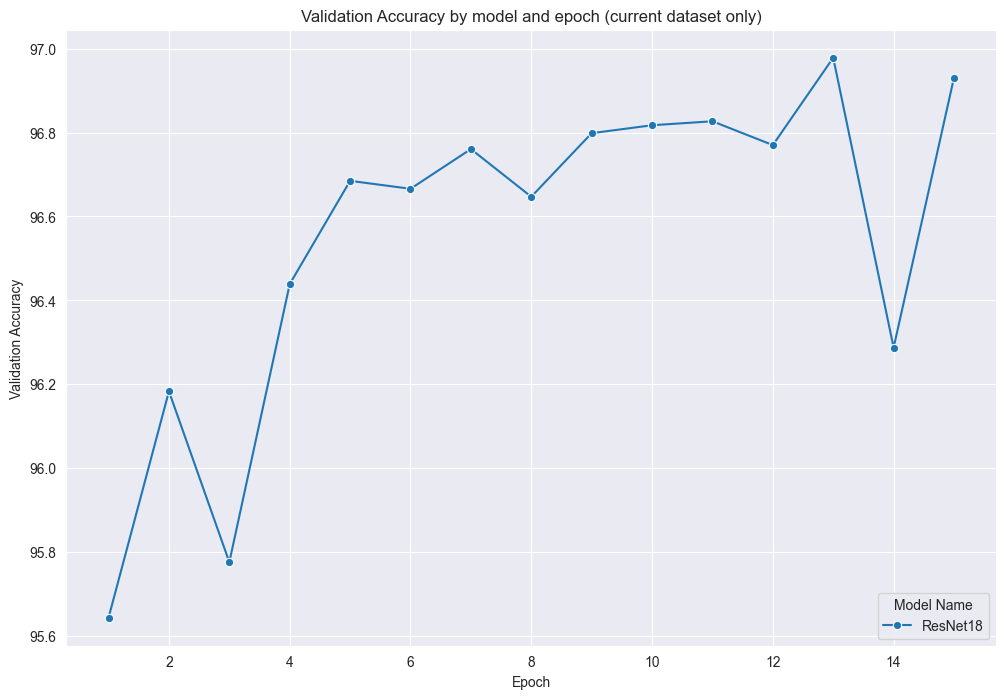

In [109]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=training_log_latest_by_model,
             x="epoch",
             y="val_accuracy",
             hue="model_name",
             style="model_name",
             markers=True)
plt.title('Validation Accuracy by model and epoch (current dataset only)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name', loc='lower right')
plt.show()

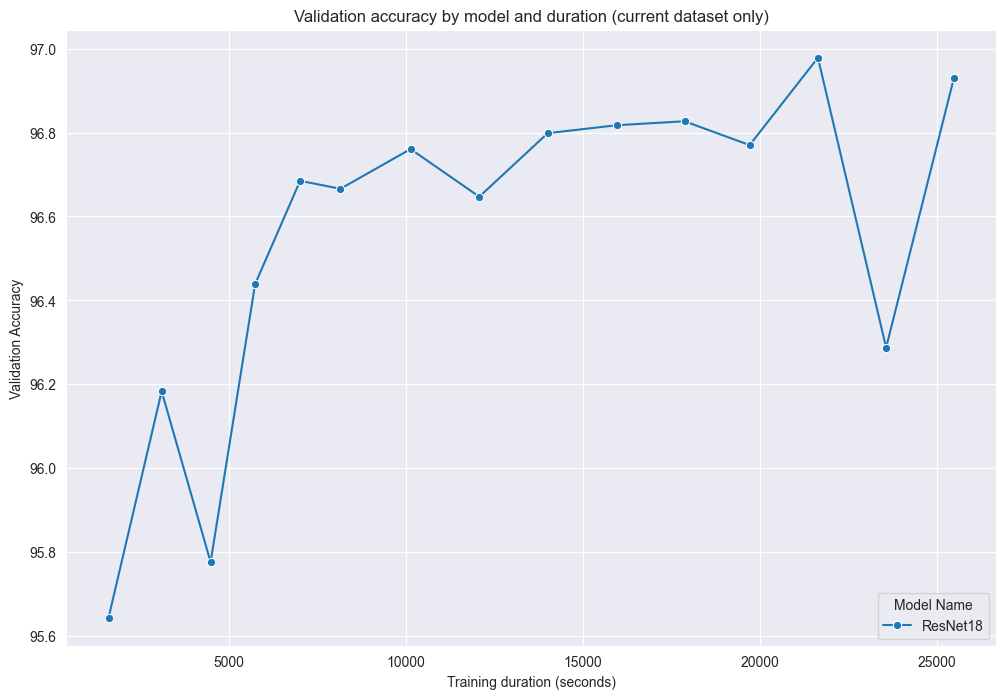

In [110]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=training_log_latest_by_model, x="training_duration", y="val_accuracy", hue="model_name", style="model_name",
             markers=True)
plt.title('Validation accuracy by model and duration (current dataset only)')
plt.xlabel('Training duration (seconds)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name', loc='lower right')
plt.show()

# Manual image classification

In [20]:
train_exploration_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
train_exploration_results = predict_model_resnet(train_exploration_loader)

In [21]:
train_bad_guesses = (train_exploration_results
.filter((pl.col("confidence") < 0.1) | (pl.col("correct_prediction") == 0))
.sort([
    (good_prediction := pl.col('label').eq(pl.col('prediction'))),
    (good_prediction - 1) * pl.col('confidence'),
    pl.col('confidence')
]))

with open("file_move_history.txt", "r") as file:
    moved_files = file.read().splitlines()

train_bad_guess_file_paths = train_bad_guesses.select("file_path").to_series().to_list()

train_bad_guess_file_paths = [fp for fp in train_bad_guess_file_paths if fp not in moved_files]

pl.DataFrame(train_bad_guess_file_paths, schema=["file_path"]).write_csv("train_holdout_bad_guesses.csv")

print(f"{len(train_bad_guess_file_paths)} files to be reclassified")

1114 files to be reclassified


In [51]:
#label_images(csv_file="train_holdout_bad_guesses.csv", output_file="train_holdout_manual_labels.csv")

Image 1/154 classified as m
Image 2/154 classified as f
Image 3/154 classified as f
Image 4/154 classified as m
Image 5/154 classified as f
Image 6/154 classified as f
Image 7/154 classified as m
Image 8/154 classified as m
Image 9/154 classified as d
Image 10/154 classified as d
Image 11/154 classified as m
Image 12/154 classified as m
Image 13/154 classified as f
Image 14/154 classified as f
Image 15/154 classified as f
Image 16/154 classified as f
Image 17/154 classified as f
Image 18/154 classified as f
Image 19/154 classified as d
Image 20/154 classified as m
Image 21/154 classified as m
Image 22/154 classified as f
Image 23/154 classified as f
Image 24/154 classified as m
Image 25/154 classified as f
Image 26/154 classified as m
Image 27/154 classified as f
Image 28/154 classified as f
Image 29/154 classified as f
Image 30/154 classified as f
Image 31/154 classified as m
Image 32/154 classified as f
Image 33/154 classified as d
Image 34/154 classified as m
Image 35/154 classified

In [52]:
#move_labeled_images("train_holdout_manual_labels.csv")

File is already in the correct folder: H:/Photos/AI/Labeled\Male\A_picture_of_a_male_pharmacist_S210374823_St50_G7.5.10174.jpeg
File is already in the correct folder: H:/Photos/AI/Labeled\Female\A_picture_of_a_female_doctor_S1407209838_St50_G7.5.2642.jpeg
File is already in the correct folder: H:/Photos/AI/Labeled\Female\a_photograph_of_a_female_photographer_S3423631971_St25_G7.5.93.jpeg
File is already in the correct folder: H:/Photos/AI/Labeled\Male\A_photograph_of_a_male_phlebotomist_S452618659_St25_G7.5.4568.jpeg
File is already in the correct folder: H:/Photos/AI/Labeled\Female\A_photograph_of_a_pharmacist_S234543248_St25_G7.5.365.jpeg
File is already in the correct folder: H:/Photos/AI/Labeled\Female\A_photograph_of_a_veterinarian_S4290879249_St24_G7.5.1032.jpeg
File is already in the correct folder: H:/Photos/AI/Labeled\Male\A_picture_of_a_male_nurse_S2079393622_St50_G7.5.13995.jpeg
File is already in the correct folder: H:/Photos/AI/Labeled\Male\A_photograph_of_a_male_veterinar

In [24]:
exploration_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
exploration_results = predict_model_resnet(exploration_loader).with_columns(
    (1 - pl.col("prob_female")).alias("prob_male")
)
exploration_results = add_occupation(exploration_results)

In [25]:
cv_bad_guesses = (exploration_results
.filter((pl.col("confidence") < 0.1) | (pl.col("correct_prediction") == 0))
.sort([
    (good_prediction := pl.col('label').eq(pl.col('prediction'))),
    (good_prediction - 1) * pl.col('confidence'),
    pl.col('confidence')
]))

with open("file_move_history.txt", "r") as file:
    moved_files = file.read().splitlines()

bad_guess_file_paths = cv_bad_guesses.select("file_path").to_series().to_list()

holdout_filtered_files = [fp for fp in bad_guess_file_paths if fp not in moved_files]
print(f"{len(holdout_filtered_files)} files to be reclassified")
pl.DataFrame(holdout_filtered_files, schema=["file_path"]).write_csv("holdout_bad_guesses.csv")

300 files to be reclassified


In [49]:
#label_images(csv_file="holdout_bad_guesses.csv", output_file="holdout_manual_labels.csv")

Image 1/300 classified as f
Image 2/300 classified as f
Image 3/300 classified as f
Image 4/300 classified as f
Image 5/300 classified as d
Image 6/300 classified as f
Image 7/300 classified as m
Image 8/300 classified as f
Image 9/300 classified as m
Image 10/300 classified as m
Image 11/300 classified as m
Image 12/300 classified as d
Image 13/300 classified as d
Image 14/300 classified as m
Image 15/300 classified as f
Image 16/300 classified as f
Image 17/300 classified as m
Image 18/300 classified as m
Image 19/300 classified as d
Image 20/300 classified as m
Image 21/300 classified as f
Image 22/300 classified as m
Image 23/300 classified as f
Image 24/300 classified as f
Image 25/300 classified as f
Image 26/300 classified as d
Image 27/300 classified as m
Image 28/300 classified as f
Image 29/300 classified as f
Image 30/300 classified as f
Image 31/300 classified as f
Image 32/300 classified as m
Image 33/300 classified as f
Image 34/300 classified as f
Image 35/300 classified

In [50]:
#move_labeled_images("holdout_manual_labels.csv")

File is already in the correct folder: H:/Photos/AI/Holdout\Female\A_photograph_of_a_female_psychologist_NPRFYNW0.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Female\A_photograph_of_a_female_psychologist_S1615707851_St30_G7.5.375.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Female\A_photograph_of_a_female_social_worker_S2200167656_St30_G7.5.1830.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Female\A_photograph_of_a_female_veterinarian_S2628066500_St30_G7.5.359.jpeg
File H:/Photos/AI/Holdout\Male\A_photograph_of_a_male_dentist_S715031565_St25_G7.5.1174.jpeg successfully moved to H:/Photos/AI/Holdout\Discard
File is already in the correct folder: H:/Photos/AI/Holdout\Female\A_photograph_of_a_female_paramedic_S3443160515_St30_G7.5.284.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Male\A_portrait_of_a_male_dentist_S3108595036_St25_G7.5.1714.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Female\A

# CV stats

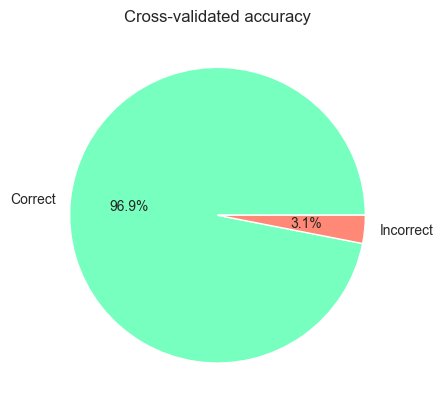

In [28]:
fig, ax = plt.subplots()
ax.pie([exploration_results.select(pl.mean("correct_prediction")).to_series().to_list()[0],
        1 - exploration_results.select(pl.mean("correct_prediction")).to_series().to_list()[0]],
       labels=["Correct", "Incorrect"],
       autopct="%1.1f%%",
       colors=["#76ffbf", "#ff8876"])
plt.title("Cross-validated accuracy")
plt.show()

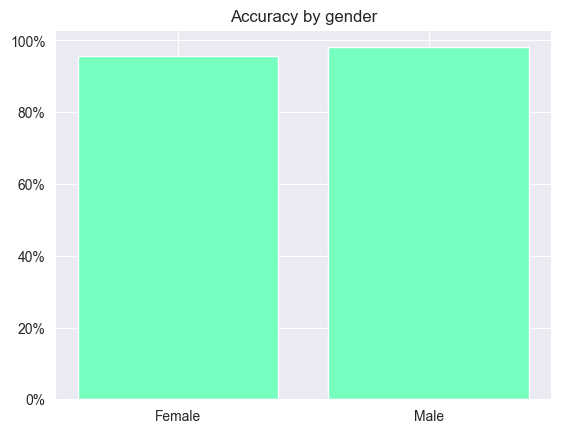

In [29]:
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

accuracy_by_gender = (exploration_results.select(["label", "correct_prediction"])
.group_by("label")
.mean()
.with_columns(
    pl.col("label").replace(idx_to_class)
))

fig, ax = plt.subplots()
ax.bar(list(zip(*accuracy_by_gender.rows()))[0], list(zip(*accuracy_by_gender.rows()))[1], color="#76ffbf")
plt.title("Accuracy by gender")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))

plt.show()

In [30]:
(exploration_results.group_by('occupation')
 .map_groups(calculate_metrics)
 .vstack(
    calculate_metrics(exploration_results)).sort("f1_score"))

occupation,accuracy,roc_auc,precision,recall,f1_score,matthews_corrcoef,cohen_kappa,pr_auc,brier_score,hamming_loss,jaccard_loss,n
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""paramedic""",0.90534,0.973419,0.874439,0.946602,0.909091,0.813454,0.81068,0.973978,0.068752,0.09466,0.166667,412
"""chiropractor""",0.949889,0.994514,0.920833,0.98441,0.951561,0.90193,0.899777,0.993785,0.032942,0.050111,0.092402,898
"""phlebotomist""",0.96114,0.993449,0.968421,0.953368,0.960836,0.922391,0.92228,0.993327,0.031365,0.03886,0.075377,386
"""dentist""",0.961686,0.991941,0.961686,0.961686,0.961686,0.923372,0.923372,0.992291,0.029681,0.038314,0.073801,522
"""pharmacist""",0.962179,0.994652,0.947826,0.978205,0.962776,0.924834,0.924359,0.994561,0.028474,0.037821,0.071776,1560
"""veterinarian""",0.967634,0.993114,0.956427,0.979911,0.968026,0.93555,0.935268,0.992734,0.028798,0.032366,0.061966,896
"""social""",0.9675,0.9948,0.941038,0.9975,0.968447,0.936688,0.935,0.993854,0.026668,0.0325,0.061176,800
"""OVERALL""",0.969312,0.995459,0.958542,0.981057,0.969669,0.938884,0.938625,0.994956,0.023835,0.030688,0.058877,10558
"""nurse""",0.974306,0.997415,0.96845,0.980556,0.974465,0.948685,0.948611,0.99746,0.01927,0.025694,0.049798,1440


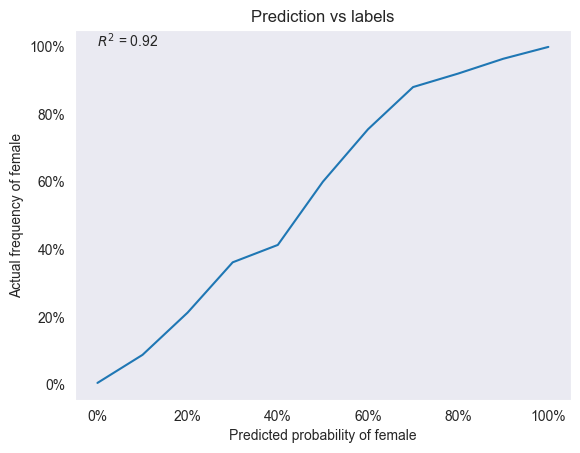

In [31]:
exploration_results_confidence = (exploration_results.select(
    pl.col("prob_female").round(1),
    pl.col("label")
)
.group_by("prob_female")
.agg(
    abs(pl.mean("label") - 1)
)
).sort("prob_female")

fig, ax = plt.subplots()
ax.plot(exploration_results_confidence["prob_female"], exploration_results_confidence["label"])
ax.set(xlabel="Predicted probability of female", ylabel="Actual frequency of female", title="Prediction vs labels")
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
ax.annotate("$R^2$ = {:.2f}".format(
    sklearn.metrics.r2_score(exploration_results_confidence["prob_female"], exploration_results_confidence["label"])),
    (0, 1))
ax.grid()
plt.show()

# Unlabeled images

In [32]:
unlabeled_dataset = ImageFolder(os.path.join(data_dir, 'Unlabeled'), transform=tensor_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

unlabeled_predictions = predict_model_resnet(unlabeled_loader)
unlabeled_predictions.drop(["label", "correct_prediction"])
unlabeled_predictions = add_occupation(unlabeled_predictions)

Lowest-confidence images


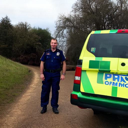

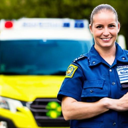

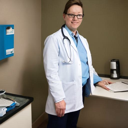

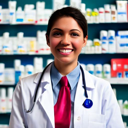

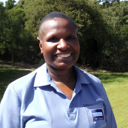

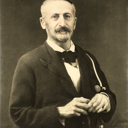

In [33]:
print("Lowest-confidence images")
for img_path in unlabeled_predictions.sort("confidence", descending=False).head(6).to_series(0):
    img = PIL.Image.open(img_path)
    display(PIL.Image.open(img_path).resize((128, 128)))

In [34]:
bls_gender = (
    pl.DataFrame({"occupation": ["nutritionist", "doctor", "chiropractor", "pharmacist", "dentist", "paramedic",
                                 "psychologist", "veterinarian", "social", "phlebotomist", "nurse"],
                  "bls_percent_female": [.880, .438, .255, .596, .366, .236, .750, .698, .815, .879, .879]})
    .sort("bls_percent_female")
    .with_columns(
        (1 - pl.col("bls_percent_female")).alias("bls_percent_male")
    ))

unlabeled_prediction_summary = (unlabeled_predictions
                                .select(["occupation", "prediction"])
                                .group_by("occupation")
                                .agg(
    pl.mean("prediction"),
    pl.count().alias("n")
)
                                .sort("prediction", descending=True)
                                .filter(pl.col("n") > 99)
                                .join(bls_gender, on="occupation", how="left"))

(unlabeled_prediction_summary.select(["occupation", "prediction", "bls_percent_male"])
 .sort("prediction",
       descending=True))

occupation,prediction,bls_percent_male
str,f64,f64
"""chiropractor""",0.955654,0.745
"""doctor""",0.95498,0.562
"""dentist""",0.86653,0.634
"""pharmacist""",0.836778,0.404
"""paramedic""",0.836735,0.764
"""psychologist""",0.741117,0.25
"""veterinarian""",0.493268,0.302
"""social""",0.477749,0.185
"""phlebotomist""",0.192893,0.121


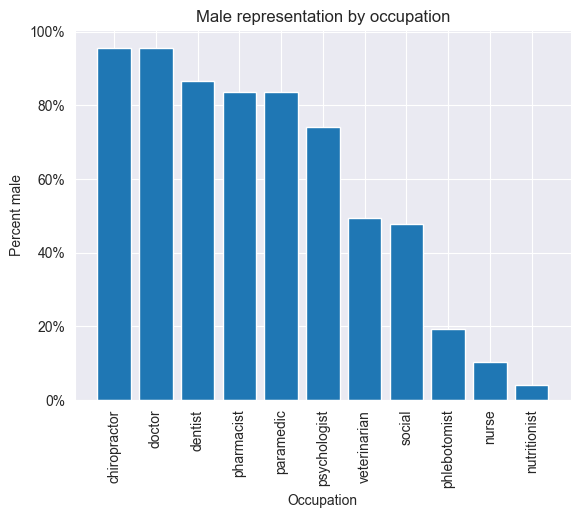

In [35]:
fig, ax = plt.subplots()
ax.bar(unlabeled_prediction_summary["occupation"].to_list(),
       unlabeled_prediction_summary["prediction"].to_list())

ax.set_title("Male representation by occupation")
ax.set_ylabel("Percent male")
ax.set_xlabel("Occupation")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
plt.xticks(unlabeled_prediction_summary["occupation"].to_list(), rotation='vertical')

plt.show()

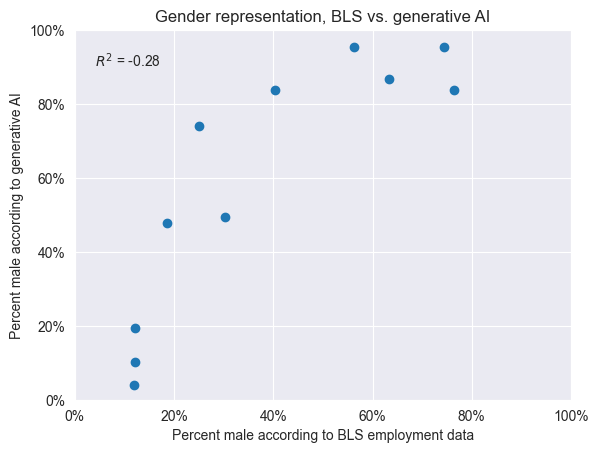

In [36]:
fig, ax = plt.subplots()
ax.scatter(unlabeled_prediction_summary["bls_percent_male"], unlabeled_prediction_summary["prediction"])
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
ax.annotate("$R^2$ = {:.2f}".format(
    sklearn.metrics.r2_score(unlabeled_prediction_summary["bls_percent_male"],
                             unlabeled_prediction_summary["prediction"])),
    (0.04, .9))
ax.set_xlabel("Percent male according to BLS employment data")
ax.set_ylabel("Percent male according to generative AI")
ax.set_title("Gender representation, BLS vs. generative AI")
plt.show()

In [40]:
unlabeled_predictions.filter(pl.col("confidence") < 0.1).sort("confidence").select("file_path").write_csv(
    "unlabeled_path_test.csv")

label_images("unlabeled_path_test.csv", "unlabeled_labels.csv")

Image 1/488 classified as d
Image 2/488 classified as f
Image 3/488 classified as d
Image 4/488 classified as f
Image 5/488 classified as f
Image 6/488 classified as d
Image 7/488 classified as f
Image 8/488 classified as f
Image 9/488 classified as m
Image 10/488 classified as f


ValueError: Only allowed values are 0, 1, 2, f, m, and d

In [38]:
#move_labeled_images("unlabeled_labels.csv")